In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
DATASET_DIR = "./data/Garbage_classification"  # Path to data
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Image dimensions
BATCH_SIZE = 32  # Batch size for training and validation

# Load training, validation, and test datasets
train_data = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",  # Converts labels to one-hot encoded format
    validation_split=0.2,  # Reserve 20% of data for validation
    subset="training",
    seed=123,  # Random seed for reproducibility
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_data = tf.keras.utils.image_dataset_from_directory(
    DATASET_DIR,
    labels="inferred",
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Class names (categories)
class_names = train_data.class_names
print("Class Names:", class_names)


Found 2526 files belonging to 6 classes.
Using 2021 files for training.
Found 2526 files belonging to 6 classes.
Using 505 files for validation.
Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


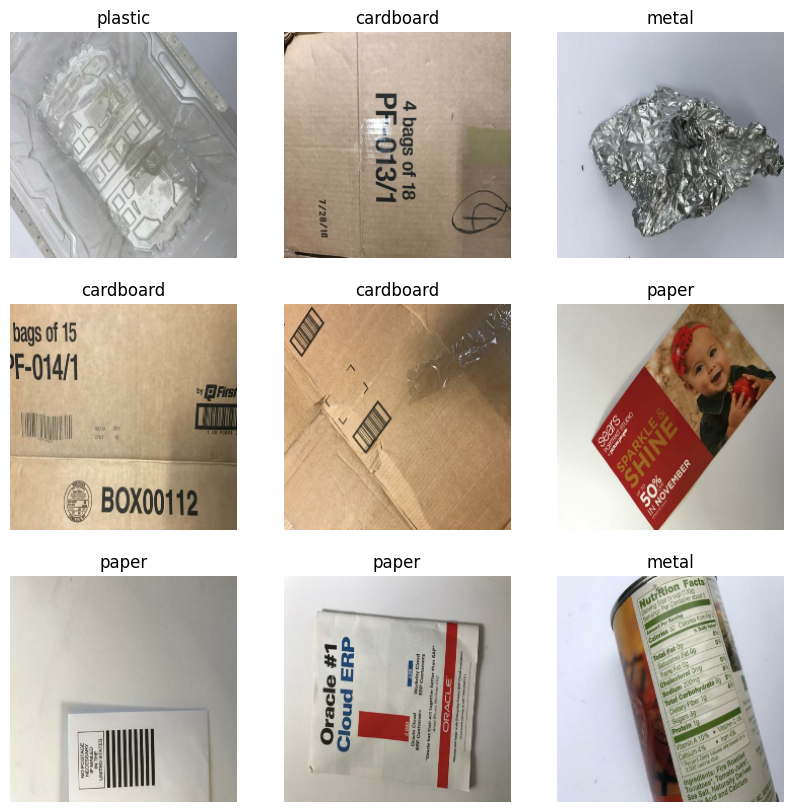

In [14]:
 # Visualize a batch of images
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):  # Take 1 batch
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [15]:
#Normalizing the data
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_data = train_data.map(normalize)
val_data = val_data.map(normalize)

In [16]:
from tensorflow.keras import layers, models

In [17]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2)
])

train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

In [20]:
# Autotuning
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [25]:
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Image size for CNN
EPOCHS = 10

In [26]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Train model
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

# Save model
model.save('cnn_garbage_classifier.h5')
print("CNN model saved as 'cnn_garbage_classifier.h5'")

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.1766 - loss: 51.2387 - val_accuracy: 0.2277 - val_loss: 1.7815
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 958ms/step - accuracy: 0.2356 - loss: 1.7841 - val_accuracy: 0.2079 - val_loss: 1.7638
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 840ms/step - accuracy: 0.2416 - loss: 1.8197 - val_accuracy: 0.2416 - val_loss: 1.7461
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 836ms/step - accuracy: 0.2177 - loss: 1.8118 - val_accuracy: 0.1980 - val_loss: 1.7417
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 836ms/step - accuracy: 0.2310 - loss: 1.9187 - val_accuracy: 0.2119 - val_loss: 1.7307
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 834ms/step - accuracy: 0.2332 - loss: 1.7344 - val_accuracy: 0.2218 - val_loss: 1.7246
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 837ms/step - accuracy: 0.2388 - loss: 1.8634 - val_accuracy: 0.2436 - val_loss: 1.7238
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 841ms/step - accuracy: 0.2334 - loss: 1.7395 - val_accura

CNN model saved as 'cnn_garbage_classifier.h5'


In [28]:
#Since the accuracy is too low doing the below steps
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

# Load Pre-trained Model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Model Architecture
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping]
)

# Save the Model
# model.save('improved_cnn_garbage_classifier.h5')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 975ms/step - accuracy: 0.2074 - loss: 1.9549 - val_accuracy: 0.2970 - val_loss: 1.9295
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 943ms/step - accuracy: 0.2363 - loss: 1.8815 - val_accuracy: 0.3822 - val_loss: 1.5762
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 60s 939ms/step - accuracy: 0.2218 - loss: 1.8297 - val_accuracy: 0.4396 - val_loss: 1.5009
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 61s 943ms/step - accuracy: 0.2449 - loss: 1.7934 - val_accuracy: 0.4515 - val_loss: 1.3352
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 60s 934ms/step - accuracy: 0.2161 - loss: 1.8314 - val_accuracy: 0.4792 - val_loss: 1.2810
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 813ms/step - accuracy: 0.2342 - loss: 1.7677 - val_accuracy: 0.5446 - val_loss: 1.1479
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 798ms/step - accuracy: 0.2269 - loss: 1.8046 - val_accuracy: 0.5584 - val_loss: 1.1904
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 798ms/

In [29]:
#The significant jump in validation accuracy (60.2%) compared to training accuracy (27.5%) after training indicates underfitting: your model isn't learning the training data adequately. This could be due to various reasons, such as insufficient model capacity, inappropriate preprocessing, or inefficiencies in the learning process. Below are steps to address this:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping

# Use EfficientNetB3 for transfer learning
base_model = EfficientNetB3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Enable fine-tuning

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model with learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Apply early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=100, callbacks=[early_stopping])

# Save the model
# model.save('fine_tuned_cnn_garbage_classifier.h5')


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 891s 13s/step - accuracy: 0.2393 - loss: 1.7674 - val_accuracy: 0.1663 - val_loss: 1.7552
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 844s 13s/step - accuracy: 0.3533 - loss: 1.5042 - val_accuracy: 0.1941 - val_loss: 1.7793
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 807s 12s/step - accuracy: 0.4261 - loss: 1.3543 - val_accuracy: 0.2178 - val_loss: 1.7650
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 780s 12s/step - accuracy: 0.4782 - loss: 1.2510 - val_accuracy: 0.4317 - val_loss: 1.4859
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 824s 13s/step - accuracy: 0.4836 - loss: 1.2216 - val_accuracy: 0.4990 - val_loss: 1.4531
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 780s 12s/step - accuracy: 0.5187 - loss: 1.1728 - val_accuracy: 0.5010 - val_loss: 1.3758
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 742s 12s/step - accuracy: 0.5228 - loss: 1.1412 - val_accuracy: 0.3960 - val_loss: 1.5710
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 738s 11

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# Pre-trained model
base_model = EfficientNetB4(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(class_names), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.00005,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
train_labels = np.concatenate([y for _, y in train_data], axis=0)
class_weights_dict = class_weight.compute_class_weight(
    'balanced', classes=np.unique(train_labels.argmax(axis=1)), y=train_labels.argmax(axis=1)
)
class_weights_dict = {i: class_weights_dict[i] for i in range(len(class_weights_dict))}

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Save model
model.save('efficientnet_garbage_classifier.h5')

# Plot training dynamics
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
37/64 ━━━━━━━━━━━━━━━━━━━━ 1:23:09 185s/step - accuracy: 0.1797 - loss: 1.8490